In [1]:
import cadprep as cpr
import nblog
from nblog import logger as lg
from nblog import NBLog as nblc
import ipynbname

In [2]:
nb_fname = ipynbname.name()

In [3]:
nbl = nblc()
lg.info(nbl.newrun)
lg.info(f'nb name: {nb_fname}')

2021-11-09 15:35:58,372 - nblog - INFO - ------------------------- NEW RUN -------------------------
2021-11-09 15:35:58,375 - nblog - INFO - nb name: telem-EML-mixed-encoding-breast


## Exploratory ML from Kaggle (like Brownlee's 'Spot Check' process)
(original was on titanic data - this is adapted to breast ca data)  
https://www.kaggle.com/lovroselic/titanic-ls-take-2

## Import Libraries

In [77]:
import numpy as np
from numpy.random import seed
from numpy.random import default_rng
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

In [5]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import tensorflow

import xgboost as xgb

2021-11-09 15:35:58.739812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 15:35:58.739854: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Prep

### Load Data and Overview

In [7]:
# define the location of the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv"
# load the dataset
dataset = pd.read_csv(url, header=None)

1. Class: no-recurrence-events, recurrence-events
2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
3. menopause: lt40, ge40, premeno.
4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
6. node-caps: yes, no.
7. deg-malig: 1, 2, 3.
8. breast: left, right.
9. breast-quad: left-up, left-low, right-up, right-low, central.
10. irradiat: yes, no.

In [8]:
colnames = ['age', 'menopause', 'tum_sz', 'inv_nodes', 'node_caps', 'deg_malig', 'lat', 'quad', 'irr', 'recurrence_class']

In [9]:
dataset.columns = colnames
dataset

,age,menopause,tum_sz,inv_nodes,node_caps,deg_malig,lat,quad,irr,recurrence_class
0,'40-49','premeno','15-19','0-2','yes','3','right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2','no','1','right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2','no','2','left','left_low','no','recurrence-events'
3,'40-49','premeno','35-39','0-2','yes','3','right','left_low','yes','no-recurrence-events'
4,'40-49','premeno','30-34','3-5','yes','2','left','right_up','no','recurrence-events'
...,...,...,...,...,...,...,...,...,...,...
281,'50-59','ge40','30-34','6-8','yes','2','left','left_low','no','no-recurrence-events'
282,'50-59','premeno','25-29','3-5','yes','2','left','left_low','yes','no-recurrence-events'
283,'30-39','premeno','30-34','6-8','yes','2','right','right_up','no','no-recurrence-events'
284,'50-59','premeno','15-19','0-2','no','2','right','left_low','no','no-recurrence-events'


We can see there are 286 observations with 9 features. We can also see there are no numerical features other than deg_malig (which is currently a string).

In [10]:
# deploy any clean and subset methods
lg.info(f'cadprep run')

2021-11-09 15:36:00,246 - nblog - INFO - cadprep run


### 2.2 Checking Missing Values

In [11]:
dataset.isnull().sum()

age                 0
menopause           0
tum_sz              0
inv_nodes           0
node_caps           8
deg_malig           0
lat                 0
quad                1
irr                 0
recurrence_class    0
dtype: int64

In [12]:
pd.DataFrame(dataset.isnull().sum(), columns=["Cnt"]).style.bar(color = "pink")

,Cnt
age,0
menopause,0
tum_sz,0
inv_nodes,0
node_caps,8
deg_malig,0
lat,0
quad,1
irr,0
recurrence_class,0


In [13]:
# dataset['node_caps'] = dataset['node_caps'].fillna(np.round(dataset['node_caps'].mean(), 0))  # impute with mean
drop_idx1 = dataset[dataset.node_caps.isnull()].index.to_list()
drop_idx2 = dataset[dataset.quad.isnull()].index.to_list()
drop_idx = drop_idx1 + drop_idx2
print(len(drop_idx))
lg.info(f'cleaning by dropping {len(drop_idx)} records')
drop_idx

2021-11-09 15:36:00,374 - nblog - INFO - cleaning by dropping 9 records


9


[20, 31, 50, 54, 71, 92, 149, 264, 240]

In [14]:
dataset.drop(index=drop_idx, inplace=True)

In [15]:
lg.info(f'cleaned input data: {type(dataset).__name__} {dataset.shape}')

2021-11-09 15:36:00,416 - nblog - INFO - cleaned input data: DataFrame (277, 10)


### 2.3 Encoding Categorical Features - binary

In [16]:
dataset.select_dtypes(exclude="number").nunique()

age                  6
menopause            3
tum_sz              11
inv_nodes            7
node_caps            2
deg_malig            3
lat                  2
quad                 5
irr                  2
recurrence_class     2
dtype: int64

Cols 4, 6, 8 & 9 (node_caps, lat, irr and class) can be encoded with the straight binary label encoder. Rest can be done with one-hot or ordinal.

In [17]:
le = LabelEncoder()
dataset['node_caps']=le.fit_transform(dataset['node_caps'])
dataset['lat']=le.fit_transform(dataset['lat'])
dataset['irr']=le.fit_transform(dataset['irr'])
dataset['recurrence_class']=le.fit_transform(dataset['recurrence_class'])
lg.info(f'simple encoding on binary categories')
dataset

2021-11-09 15:36:00,457 - nblog - INFO - simple encoding on binary categories


,age,menopause,tum_sz,inv_nodes,node_caps,deg_malig,lat,quad,irr,recurrence_class
0,'40-49','premeno','15-19','0-2',1,'3',1,'left_up',0,1
1,'50-59','ge40','15-19','0-2',0,'1',1,'central',0,0
2,'50-59','ge40','35-39','0-2',0,'2',0,'left_low',0,1
3,'40-49','premeno','35-39','0-2',1,'3',1,'left_low',1,0
4,'40-49','premeno','30-34','3-5',1,'2',0,'right_up',0,1
...,...,...,...,...,...,...,...,...,...,...
281,'50-59','ge40','30-34','6-8',1,'2',0,'left_low',0,0
282,'50-59','premeno','25-29','3-5',1,'2',0,'left_low',1,0
283,'30-39','premeno','30-34','6-8',1,'2',1,'right_up',0,0
284,'50-59','premeno','15-19','0-2',0,'2',1,'left_low',0,0


For col 4 node_caps  yes = 1,   no = 0  
For col 6 lat right = 1, left = 0   
For col 8 irr  yes = 1,   no = 0  
For col 9 class recurrence = 1

### 2.4a Encoding Categorical Features ordinal

In [18]:
oe = OrdinalEncoder()
dataset['deg_malig_oe']=oe.fit_transform(dataset['deg_malig'].to_frame())
dataset.drop(columns='deg_malig', inplace=True)
lg.info(f'ordinal encoding on suitable categories')

2021-11-09 15:36:00,488 - nblog - INFO - ordinal encoding on suitable categories


In [19]:
dataset

,age,menopause,tum_sz,inv_nodes,node_caps,lat,quad,irr,recurrence_class,deg_malig_oe
0,'40-49','premeno','15-19','0-2',1,1,'left_up',0,1,2.0
1,'50-59','ge40','15-19','0-2',0,1,'central',0,0,0.0
2,'50-59','ge40','35-39','0-2',0,0,'left_low',0,1,1.0
3,'40-49','premeno','35-39','0-2',1,1,'left_low',1,0,2.0
4,'40-49','premeno','30-34','3-5',1,0,'right_up',0,1,1.0
...,...,...,...,...,...,...,...,...,...,...
281,'50-59','ge40','30-34','6-8',1,0,'left_low',0,0,1.0
282,'50-59','premeno','25-29','3-5',1,0,'left_low',1,0,1.0
283,'30-39','premeno','30-34','6-8',1,1,'right_up',0,0,1.0
284,'50-59','premeno','15-19','0-2',0,1,'left_low',0,0,1.0


### 2.4b Encoding Categorical Features - one-hot

In [20]:
dataset = pd.get_dummies(dataset, drop_first=False)
lg.info(f'one-hot encoding on remaining (unordered) categories')
dataset

2021-11-09 15:36:00,542 - nblog - INFO - one-hot encoding on remaining (unordered) categories


,node_caps,lat,irr,recurrence_class,deg_malig_oe,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',...,inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',quad_'central',quad_'left_low',quad_'left_up',quad_'right_low',quad_'right_up'
0,1,1,0,1,2.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0.0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,1.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,2.0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,1.0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,0,0,0,1.0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
282,1,0,1,0,1.0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
283,1,1,0,0,1.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
284,0,1,0,0,1.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


One-Hot Encoded the remaining categorical features.

### 2.5 Dataset Reordering

In [21]:
rec_class = dataset.recurrence_class
rec_class

0      1
1      0
2      1
3      0
4      1
      ..
281    0
282    0
283    0
284    0
285    0
Name: recurrence_class, Length: 277, dtype: int64

In [22]:
dataset = dataset.drop(columns='recurrence_class')

In [23]:
dataset.insert(loc=len(dataset.columns), column='y', value=rec_class)

In [24]:
dataset

,node_caps,lat,irr,deg_malig_oe,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',...,inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',quad_'central',quad_'left_low',quad_'left_up',quad_'right_low',quad_'right_up',y
0,1,1,0,2.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,1,1,2.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,1.0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,0,0,1.0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
282,1,0,1,1.0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
283,1,1,0,1.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
284,0,1,0,1.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


Re-ordered the label column into the rightmost of the dataset.

In [25]:
dataset.columns

Index(['node_caps', 'lat', 'irr', 'deg_malig_oe', 'age_'20-29'', 'age_'30-39'',
       'age_'40-49'', 'age_'50-59'', 'age_'60-69'', 'age_'70-79'',
       'menopause_'ge40'', 'menopause_'lt40'', 'menopause_'premeno'',
       'tum_sz_'0-4'', 'tum_sz_'10-14'', 'tum_sz_'15-19'', 'tum_sz_'20-24'',
       'tum_sz_'25-29'', 'tum_sz_'30-34'', 'tum_sz_'35-39'', 'tum_sz_'40-44'',
       'tum_sz_'45-49'', 'tum_sz_'5-9'', 'tum_sz_'50-54'', 'inv_nodes_'0-2'',
       'inv_nodes_'12-14'', 'inv_nodes_'15-17'', 'inv_nodes_'24-26'',
       'inv_nodes_'3-5'', 'inv_nodes_'6-8'', 'inv_nodes_'9-11'',
       'quad_'central'', 'quad_'left_low'', 'quad_'left_up'',
       'quad_'right_low'', 'quad_'right_up'', 'y'],
      dtype='object')

### 3.1 Convert Data to np array

In [26]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [48]:
X_cols = dataset.columns[:-1]
X_cols

Index(['node_caps', 'lat', 'irr', 'deg_malig_oe', 'age_'20-29'', 'age_'30-39'',
       'age_'40-49'', 'age_'50-59'', 'age_'60-69'', 'age_'70-79'',
       'menopause_'ge40'', 'menopause_'lt40'', 'menopause_'premeno'',
       'tum_sz_'0-4'', 'tum_sz_'10-14'', 'tum_sz_'15-19'', 'tum_sz_'20-24'',
       'tum_sz_'25-29'', 'tum_sz_'30-34'', 'tum_sz_'35-39'', 'tum_sz_'40-44'',
       'tum_sz_'45-49'', 'tum_sz_'5-9'', 'tum_sz_'50-54'', 'inv_nodes_'0-2'',
       'inv_nodes_'12-14'', 'inv_nodes_'15-17'', 'inv_nodes_'24-26'',
       'inv_nodes_'3-5'', 'inv_nodes_'6-8'', 'inv_nodes_'9-11'',
       'quad_'central'', 'quad_'left_low'', 'quad_'left_up'',
       'quad_'right_low'', 'quad_'right_up''],
      dtype='object')

In [27]:
print(X)

[[1. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [28]:
print(y)

[1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0
 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Separated the features as x and the dependant variable as y. Both is transformed to numpy array for modelling function to work.

### 3.1 Separate Training and Test Sets

In [29]:
testsize=0.3
randomstate=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
lg.info(f'train-test split. Size: {testsize}, Rand state: {randomstate}')

2021-11-09 15:36:00,735 - nblog - INFO - train-test split. Size: 0.3, Rand state: 0


In [30]:
print(X_train)

[[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]]


In [31]:
print(y_train)

[0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0
 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 1 1 1 0 0]


In [32]:
print(X_test)

[[0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 0. 0.]]


In [33]:
print(y_test)

[0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 0 0 0 0 0 1 0 0 0 0]


In [34]:
lg.info(f'encoded training data: {type(X_train).__name__} {X_train.shape}')

2021-11-09 15:36:00,848 - nblog - INFO - encoded training data: ndarray (193, 36)


### 3.2 Scaling Based on the Training Set

In [35]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
print(X_train)

[[-0.49513765  1.05871579 -0.55141097 ...  1.41972709 -0.25748465
  -0.36782349]
 [-0.49513765 -0.94454056  1.8135294  ...  1.41972709 -0.25748465
  -0.36782349]
 [-0.49513765 -0.94454056 -0.55141097 ... -0.70436073 -0.25748465
  -0.36782349]
 ...
 [ 2.01964041 -0.94454056 -0.55141097 ... -0.70436073 -0.25748465
  -0.36782349]
 [-0.49513765  1.05871579 -0.55141097 ...  1.41972709 -0.25748465
  -0.36782349]
 [-0.49513765  1.05871579 -0.55141097 ... -0.70436073 -0.25748465
   2.71869534]]


In [37]:
print(X_test)

[[-0.49513765  1.05871579 -0.55141097 ...  1.41972709 -0.25748465
  -0.36782349]
 [-0.49513765  1.05871579 -0.55141097 ... -0.70436073  3.88372673
  -0.36782349]
 [-0.49513765 -0.94454056 -0.55141097 ... -0.70436073 -0.25748465
  -0.36782349]
 ...
 [-0.49513765 -0.94454056 -0.55141097 ... -0.70436073 -0.25748465
  -0.36782349]
 [-0.49513765 -0.94454056 -0.55141097 ... -0.70436073 -0.25748465
  -0.36782349]
 [ 2.01964041  1.05871579 -0.55141097 ...  1.41972709 -0.25748465
  -0.36782349]]


Scale the value of training set to between -3 and 3 to make sure no feature overwhelm the others. The test set is scaled using same scale as training set.

## Prep for evaluation (confusion matrix)

In [38]:
def plot_CM(model, clf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6))
    fig.suptitle(clf)
    cm_train=confusion_matrix(y_train, model.predict(X_train), normalize = 'pred', labels = model.classes_)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
    disp_train.plot(ax=ax1)
    disp_train.ax_.set_title('Train')
    cm_test=confusion_matrix(y_test, model.predict(X_test), normalize = 'pred', labels = model.classes_)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
    disp_test.plot(ax=ax2)
    disp_test.ax_.set_title('Test')
    plt.show()

In [73]:
unique, counts = np.unique(y_train, return_counts=True)
table = np.asarray((unique, counts)).T.astype('float')
print(table)
tots = np.sum(counts).astype('float')
tots
table[:,1]=table[:,1]/tots
table

[[  0. 135.]
 [  1.  58.]]


array([[0.        , 0.69948187],
       [1.        , 0.30051813]])

In [76]:
print(f'    % recurrence cases in X_train {100*table[1,1]:.2f}')
print(f'% non-recurrence cases in X_train {100*table[0,1]:.2f}')

    % recurrence cases in X_train 30.05
% non-recurrence cases in X_train 69.95


## Random Guess

In [104]:
pc_pos = 10  # percentage of ones wanted (positives) in the random guess array
p1=(100-pc_pos)/100.0
p2=(pc_pos)/100.0
print(p1, 'zeros to', p2, 'ones')

0.9 zeros to 0.1 ones


In [105]:
# make random guess arrays for train and test
rng = default_rng()
y_train_rg = rng.choice([0,1], size=(len(y_train),), p=[p1, p2])
y_test_rg  = rng.choice([0,1], size=(len(y_test),) , p=[p1, p2])

In [141]:
y_real = y_train
y_pred = y_train_rg
# y_real = np.array([1,0,1,0,1,0,1,0])
# y_pred = np.array([1,0,1,0,1,0,0,0])

In [197]:
class cmbw():
    """
    Confusion matrix BW version
    Takes in y_real and y_pred as arguments
    methods:
    prntcm - prints confusion matrix
    prntpr - prints precision and recall
    """
    def __init__(self, y_real, y_pred):
        self.y_real   = y_real
        self.y_pred   = y_pred
        self.resulist = self.resulist()
        self.resuarr  = self.resuarr()
        self.clasrp()
        
    def resulist(self):
        return list(zip(self.y_real, self.y_pred))
        
    def resuarr(self):
        resuarr = np.array([[0,0],[0,0]])
        for t in self.resulist:
            if t[0] == 1:         # cond pos
                if t[1] == 1:     # ...and pred pos
                    resuarr[1,1]+=1  # tp
                else:             # ...and pred neg
                    resuarr[1,0]+=1  # fn
            else:                 # cond neg
                if t[1] == 1:     # ...and pred pos
                    resuarr[0,1]+=1  # fp
                else:             # ...and pred neg
                    resuarr[0,0]+=1  # tn
        return resuarr

    def clasrp(self):
        (tn, fp, fn, tp) = self.resuarr.ravel()
        self.tn = tn
        self.fp = fp
        self.fn = fn
        self.tp = tp
        self.tnr = tn/(tn+fn)
        self.tpr = tp/(tp+fp)
        self.fnr = fn/(tn+fn)
        self.fpr = fp/(tp+fp)        
        self.precision = tp/(tp+fp) # PPV
        self.recall    = tp/(tp+fn) # sensitivity
        self.accuracy  = (tp+tn)/(tp+fp+tn+fn)
        self.F1score   = tp/(tp+(fp+fn)/2)
        return None
    
    def prntcmt(self):
        """print confusion matrix (totals)"""
        (tn, fp, fn, tp) = self.resuarr.ravel()
        print('-------------------------')
        print('       | pred n',  '| pred p')
        print('-------------------------')
        print('cond n | tn', tn, ' | fp', fp)
        print('cond p | fn', fn, ' | tp', tp)
        print('-------------------------')

    def prntcmp(self):
        """print confusion matrix (proportions)"""
        (tn, fp, fn, tp) = self.resuarr.ravel()
        tnr = np.round(tn/(tn+fn),2)
        tpr = np.round(tp/(tp+fp),2)
        fnr = np.round(fn/(tn+fn),2)
        fpr = np.round(fp/(tp+fp),2)
        print('----------------------------')
        print('       | pred n ',  ' | pred p')
        print('----------------------------')
        print('cond n | tnr', tnr, ' | fpr', fpr)
        print('cond p | fnr', fnr, ' | tpr', tpr)
        print('----------------------------')
        return None

    def prntpr(self):
        """print precision, recall and accuracy"""
        (tn, fp, fn, tp) = self.resuarr.ravel()
        precision = tp/(tp+fp) # PPV
        recall    = tp/(tp+fn) # sensitivity
        accuracy  = (tp+tn)/(tp+fp+tn+fn)
        F1score   = tp/(tp+(fp+fn)/2)
        print(f' precision: {precision:.2f}')
        print(f'    recall: {recall:.2f}')
        print(f'  accuracy: {accuracy:.2f}')
        print(f'  F1-score: {F1score:.2f}')
        return None

In [198]:
cm1 = cmbw(y_real, y_pred)
cm1.prntcmp()
cm1.prntcmt()
cm1.prntpr()

----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.8  | fpr 0.0
cond p | fnr 0.2  | tpr 1.0
----------------------------
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 4  | fp 0
cond p | fn 1  | tp 3
-------------------------
 precision: 1.00
    recall: 0.75
  accuracy: 0.88
  F1-score: 0.86


-------------------------
       | pred n | pred p
-------------------------
cond n | tn 120  | fp 15
cond p | fn 52  | tp 6
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.7  | fpr 0.71
cond p | fnr 0.3  | tpr 0.29
----------------------------
 precision: 0.29
    recall: 0.10
  accuracy: 0.65
  F1-score: 0.15


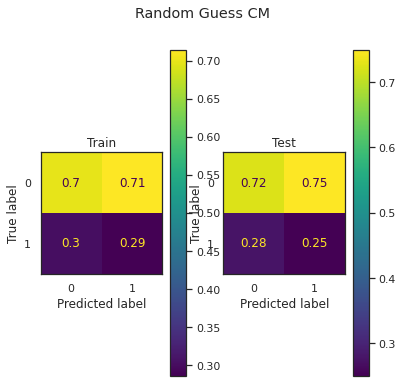

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 55  | fp 6
cond p | fn 21  | tp 2
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.72  | fpr 0.75
cond p | fnr 0.28  | tpr 0.25
----------------------------
 precision: 0.25
    recall: 0.09
  accuracy: 0.68
  F1-score: 0.13


In [199]:
cmrg = cmbw(y_train, y_train_rg)
cmrg.prntcmt()
cmrg.prntcmp()
cmrg.prntpr()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6))
fig.suptitle('Random Guess CM')
cm_train=confusion_matrix(y_train, y_train_rg, normalize = 'pred', labels =[0,1])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0,1])
disp_train.plot(ax=ax1)
disp_train.ax_.set_title('Train')
cm_test=confusion_matrix(y_test, y_test_rg, normalize = 'pred', labels = [0,1])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp_test.plot(ax=ax2)
disp_test.ax_.set_title('Test')
plt.show()
cmrg = cmbw(y_test, y_test_rg)
cmrg.prntcmt()
cmrg.prntcmp()
cmrg.prntpr()

## DNN

In [181]:
seed(13)
tensorflow.random.set_seed(13)

dnn_model = Sequential()
n_cols = X.shape[1]
dnn_model.add(Dense(128, activation="relu", input_shape = (n_cols,))) 
dnn_model.add(Dense(16, activation="relu"))
dnn_model.add(Dense(1, activation="sigmoid"))            
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               4736      
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
_________________________________________________________________


In [182]:
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_accuracy')
dnn_model.fit(X_train,y_train, validation_data=(X_test,y_test), callbacks=[early_stopping_monitor], epochs=200,batch_size=256, verbose=0)

In [183]:
def plot_loss(loss,val_loss):
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_accuracy(acc,val_acc):
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

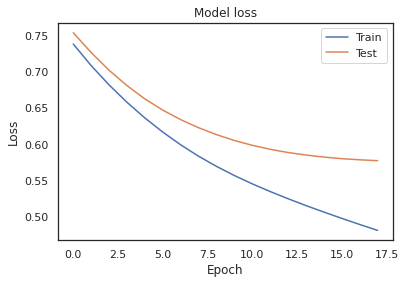

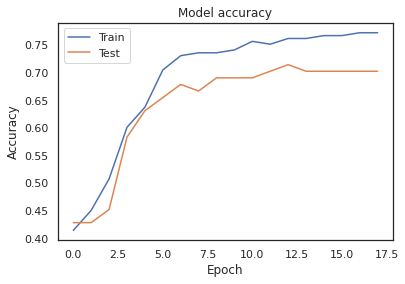

3/3 [==============================] - 0s 3ms/step - loss: 0.5774 - accuracy: 0.7024
Train accuracy: 78.24 %
Accuracy: 70.24 %
Overfit: 8.00 % 


In [184]:
plot_loss(dnn_model.history.history['loss'], dnn_model.history.history['val_loss'])
plot_accuracy(dnn_model.history.history['accuracy'], dnn_model.history.history['val_accuracy'])

_, train_dnn_accuracy = dnn_model.evaluate(X_train, y_train)
_, dnn_accuracy = dnn_model.evaluate(X_test, y_test)
print('Train accuracy: {:.2f} %'.format(train_dnn_accuracy*100))
print('Accuracy: {:.2f} %'.format(dnn_accuracy*100))
print('Overfit: {:.2f} % '.format((train_dnn_accuracy - dnn_accuracy)*100))

In [186]:
y_train

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0])

In [217]:
y_pred_tr = dnn_model.predict(X_train)
y_pred_te = dnn_model.predict(X_test)

cmrgtr = cmbw(y_train, y_pred_tr)
cmrgtr.prntcmt()
cmrgtr.prntcmp()
cmrgtr.prntpr()

cmrgte = cmbw(y_test, y_pred_te)
cmrgte.prntcmt()
cmrgte.prntcmp()
cmrgte.prntpr()
dnn_f1score = cmrgte.F1score
dnn_f1score

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 135  | fp 0
cond p | fn 58  | tp 0
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.7  | fpr nan
cond p | fnr 0.3  | tpr nan
----------------------------
 precision: nan
    recall: 0.00
  accuracy: 0.70
  F1-score: 0.00
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 61  | fp 0
cond p | fn 23  | tp 0
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.73  | fpr nan
cond p | fnr 0.27  | tpr nan
----------------------------
 precision: nan
    recall: 0.00
  accuracy: 0.73
  F1-score: 0.00


/tmp/ipykernel_382/786255800.py:41: RuntimeWarning: invalid value encountered in long_scalars
  self.tpr = tp/(tp+fp)
/tmp/ipykernel_382/786255800.py:43: RuntimeWarning: invalid value encountered in long_scalars
  self.fpr = fp/(tp+fp)
/tmp/ipykernel_382/786255800.py:44: RuntimeWarning: invalid value encountered in long_scalars
  self.precision = tp/(tp+fp) # PPV
/tmp/ipykernel_382/786255800.py:64: RuntimeWarning: invalid value encountered in long_scalars
  tpr = np.round(tp/(tp+fp),2)
/tmp/ipykernel_382/786255800.py:66: RuntimeWarning: invalid value encountered in long_scalars
  fpr = np.round(fp/(tp+fp),2)
/tmp/ipykernel_382/786255800.py:78: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp) # PPV


0.0

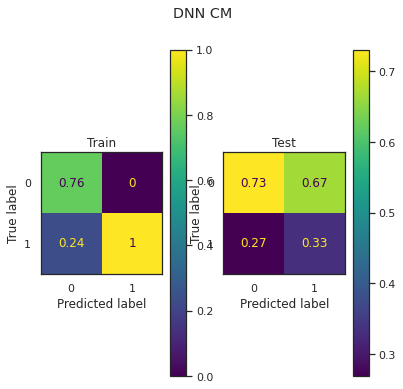

In [189]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6))
fig.suptitle('DNN CM')
cm_train=confusion_matrix(y_train, np.rint(dnn_model.predict(X_train)), normalize = 'pred', labels =[0,1])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0,1])
disp_train.plot(ax=ax1)
disp_train.ax_.set_title('Train')
cm_test=confusion_matrix(y_test, np.rint(dnn_model.predict(X_test)), normalize = 'pred', labels = [0,1])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp_test.plot(ax=ax2)
disp_test.ax_.set_title('Test')
plt.show()

## Random Forest Classifier

In [193]:
rf_model = RandomForestClassifier(max_depth=4, n_estimators= 75, max_features='auto')
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=75)

In [218]:
y_pred_tr = rf_model.predict(X_train)
y_pred_te = rf_model.predict(X_test)

cmrgtr = cmbw(y_train, y_pred_tr)
cmrgtr.prntcmt()
cmrgtr.prntcmp()
cmrgtr.prntpr()

cmrgte = cmbw(y_test, y_pred_te)
cmrgte.prntcmt()
cmrgte.prntcmp()
cmrgte.prntpr()
rf_f1score = cmrgte.F1score
rf_f1score

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 134  | fp 1
cond p | fn 31  | tp 27
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.81  | fpr 0.04
cond p | fnr 0.19  | tpr 0.96
----------------------------
 precision: 0.96
    recall: 0.47
  accuracy: 0.83
  F1-score: 0.63
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 58  | fp 3
cond p | fn 17  | tp 6
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.77  | fpr 0.33
cond p | fnr 0.23  | tpr 0.67
----------------------------
 precision: 0.67
    recall: 0.26
  accuracy: 0.76
  F1-score: 0.38


0.375

Train: 83.42 %
Test: 76.19 %
Overfit: 7.23 %


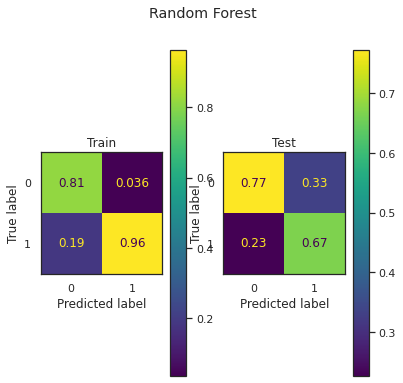

In [195]:
rf_train_score = rf_model.score(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)
print("Train: {:.2f} %".format(rf_train_score * 100))
print("Test: {:.2f} %".format(rf_accuracy*100))
print('Overfit: {:.2f} %'.format((rf_train_score-rf_accuracy)*100))
plot_CM(rf_model, "Random Forest")

In [49]:
features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

RF_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


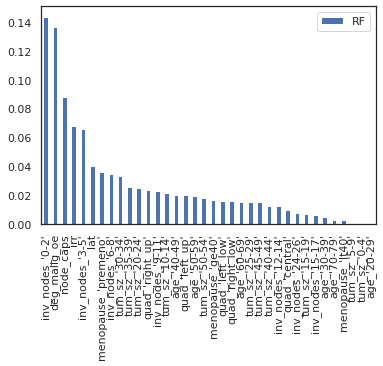

In [50]:
importances = pd.DataFrame({"RF":features})
importances.sort_values("RF", ascending = False, inplace=True)
RF_best_features = list(importances[importances.RF > 0.03].index)
importances.plot.bar()
print("RF_best_features:",RF_best_features, len(RF_best_features))

## XGBoost

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 134  | fp 1
cond p | fn 57  | tp 1
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.7  | fpr 0.5
cond p | fnr 0.3  | tpr 0.5
----------------------------
 precision: 0.50
    recall: 0.02
  accuracy: 0.70
  F1-score: 0.03
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 61  | fp 0
cond p | fn 22  | tp 1
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.73  | fpr 0.0
cond p | fnr 0.27  | tpr 1.0
----------------------------
 precision: 1.00
    recall: 0.04
  accuracy: 0.74
  F1-score: 0.08
Train: 69.95 %
Test: 73.81 %
Overfit: -3.86 %


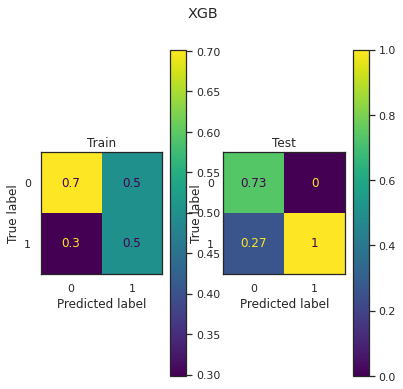

XGB best features ['f24', 'f0', 'f3', 'f2', 'f28', 'f29', 'f35', 'f30', 'f18', 'f19', 'f34', 'f23', 'f8']


In [221]:
xgb_model = xgb.XGBClassifier(learning_rate= 0.01, 
                              max_depth= 10, n_estimators= 250, min_child_weight = 0.5, reg_lambda= 100, subsample= 0.9, 
                              gamma=0.5,colsample_bytree = 0.4, colsample_bylevel = 0.6,
                              use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_train_score = xgb_model.score(X_train, y_train)
xgb_accuracy = xgb_model.score(X_test, y_test)

y_pred_tr = xgb_model.predict(X_train)
y_pred_te = xgb_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
xgb_f1score = cmte.F1score
xgb_f1score

print("Train: {:.2f} %".format(xgb_train_score*100))
print("Test: {:.2f} %".format(xgb_accuracy*100))
print('Overfit: {:.2f} %'.format((xgb_train_score-xgb_accuracy)*100))

plot_CM(xgb_model, "XGB")

weights = xgb_model.get_booster().get_score(importance_type="gain")
weights = [(weights[w],w) for w in sorted(weights, key=weights.get, reverse=True)]
XGB_features = [w[1] for w in weights]
print("XGB best features", XGB_features)

## SVM Classifier

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 133  | fp 2
cond p | fn 27  | tp 31
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.83  | fpr 0.06
cond p | fnr 0.17  | tpr 0.94
----------------------------
 precision: 0.94
    recall: 0.53
  accuracy: 0.85
  F1-score: 0.68
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 54  | fp 7
cond p | fn 16  | tp 7
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.77  | fpr 0.5
cond p | fnr 0.23  | tpr 0.5
----------------------------
 precision: 0.50
    recall: 0.30
  accuracy: 0.73
  F1-score: 0.38
Train: 84.97 %
Test: 72.62 %
Overfit: 12.36 %


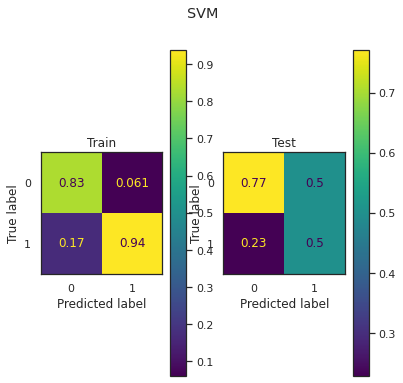

SVM_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


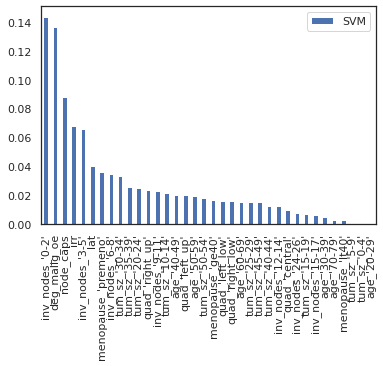

In [222]:
SVM_model = SVC(C = 100, gamma= 0.001, kernel='rbf', probability=True, random_state = 13)
SVM_model.fit(X_train, y_train)

y_pred_tr = SVM_model.predict(X_train)
y_pred_te = SVM_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
SVM_f1score = cmte.F1score
SVM_f1score

svm_train_score = SVM_model.score(X_train, y_train)
SVM_accuracy = SVM_model.score(X_test, y_test)
print("Train: {:.2f} %".format(svm_train_score*100))
print("Test: {:.2f} %".format(SVM_accuracy*100))
print('Overfit: {:.2f} %'.format((svm_train_score - SVM_accuracy)*100))

plot_CM(SVM_model, "SVM")

features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"SVM":features})
importances.sort_values("SVM", ascending = False, inplace=True)
importances
SVM_best_features = list(importances[importances.SVM > 0.03].index)
importances.plot.bar()
print("SVM_best_features:",SVM_best_features, len(SVM_best_features))

## Logistic Regression

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 124  | fp 11
cond p | fn 28  | tp 30
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.82  | fpr 0.27
cond p | fnr 0.18  | tpr 0.73
----------------------------
 precision: 0.73
    recall: 0.52
  accuracy: 0.80
  F1-score: 0.61
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 53  | fp 8
cond p | fn 17  | tp 6
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.76  | fpr 0.57
cond p | fnr 0.24  | tpr 0.43
----------------------------
 precision: 0.43
    recall: 0.26
  accuracy: 0.70
  F1-score: 0.32
Train: 79.79 %
Test: 70.24 %
Overfit: 9.55 %


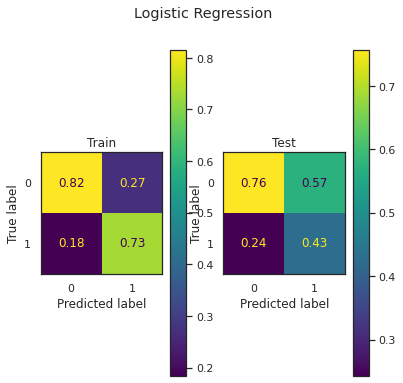

LR_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


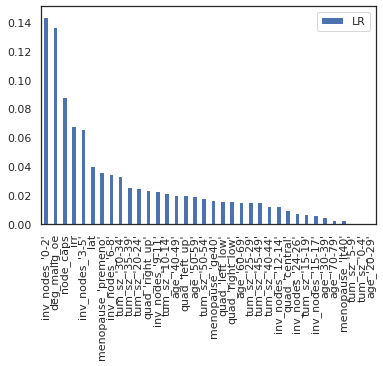

In [223]:
LR_model = LogisticRegression(solver='liblinear', C=1000, penalty='l2', random_state=13)
LR_model.fit(X_train, y_train)

y_pred_tr = LR_model.predict(X_train)
y_pred_te = LR_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
LR_f1score = cmte.F1score
LR_f1score

LR_train_score = LR_model.score(X_train, y_train)
LR_accuracy = LR_model.score(X_test, y_test)
print("Train: {:.2f} %".format(LR_train_score*100))
print("Test: {:.2f} %".format(LR_accuracy*100))
print('Overfit: {:.2f} %'.format((LR_train_score-LR_accuracy)*100))

plot_CM(LR_model, "Logistic Regression")


features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"LR":features})
importances.sort_values("LR", ascending = False, inplace=True)
importances
LR_best_features = list(importances[importances.LR > 0.03].index)
importances.plot.bar()
print("LR_best_features:",LR_best_features, len(LR_best_features))

## KNN Classifier

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 132  | fp 3
cond p | fn 50  | tp 8
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.73  | fpr 0.27
cond p | fnr 0.27  | tpr 0.73
----------------------------
 precision: 0.73
    recall: 0.14
  accuracy: 0.73
  F1-score: 0.23
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 58  | fp 3
cond p | fn 19  | tp 4
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.75  | fpr 0.43
cond p | fnr 0.25  | tpr 0.57
----------------------------
 precision: 0.57
    recall: 0.17
  accuracy: 0.74
  F1-score: 0.27
Train: 72.54 %
Test: 73.81 %
Overfit: -1.27 %


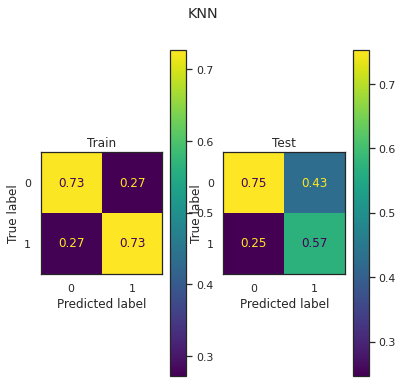

KNN_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


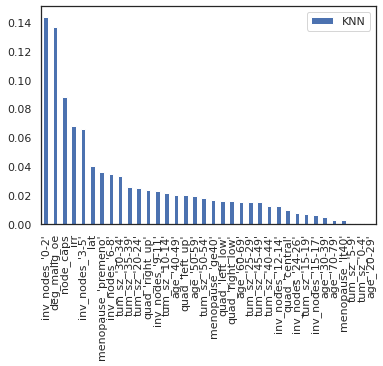

In [224]:
KNN_model = KNeighborsClassifier(n_neighbors=12,metric='manhattan',weights='uniform')
KNN_model.fit(X_train, y_train)

y_pred_tr = KNN_model.predict(X_train)
y_pred_te = KNN_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
KNN_f1score = cmte.F1score
KNN_f1score

KNN_train_score = KNN_model.score(X_train, y_train)
KNN_accuracy = KNN_model.score(X_test, y_test)
print("Train: {:.2f} %".format(KNN_train_score*100))
print("Test: {:.2f} %".format(KNN_accuracy*100))
print('Overfit: {:.2f} %'.format((KNN_train_score-KNN_accuracy)*100))

plot_CM(KNN_model, "KNN")

features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"KNN":features})
importances.sort_values("KNN", ascending = False, inplace=True)
importances
KNN_best_features = list(importances[importances.KNN > 0.03].index)
importances.plot.bar()
print("KNN_best_features:",KNN_best_features, len(KNN_best_features))

## AdaBoost Classifier

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 135  | fp 0
cond p | fn 17  | tp 41
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.89  | fpr 0.0
cond p | fnr 0.11  | tpr 1.0
----------------------------
 precision: 1.00
    recall: 0.71
  accuracy: 0.91
  F1-score: 0.83
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 54  | fp 7
cond p | fn 14  | tp 9
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.79  | fpr 0.44
cond p | fnr 0.21  | tpr 0.56
----------------------------
 precision: 0.56
    recall: 0.39
  accuracy: 0.75
  F1-score: 0.46
Train: 91.19 %
Test: 75.00 %
Overfit: 16.19 %


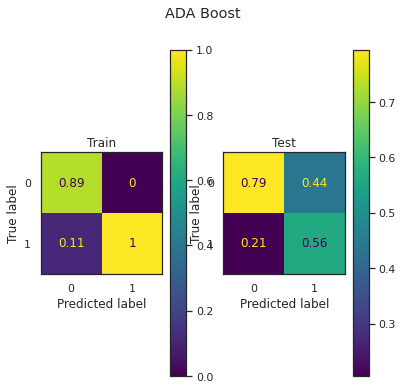

ADA_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


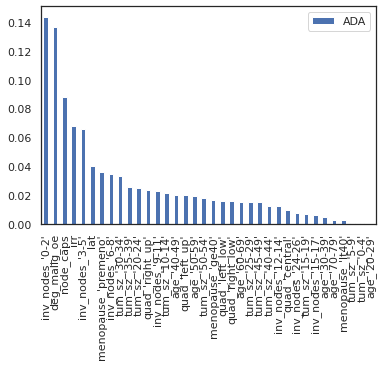

In [225]:
ADA_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4, min_samples_leaf=4, max_features=0.7, min_samples_split= 5), 
                               n_estimators=100, learning_rate=0.01, random_state=13) 
ADA_model.fit(X_train,y_train)

y_pred_tr = ADA_model.predict(X_train)
y_pred_te = ADA_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
ADA_f1score = cmte.F1score
ADA_f1score

ADA_train_score = ADA_model.score(X_train, y_train)
ADA_accuracy = ADA_model.score(X_test, y_test)
print("Train: {:.2f} %".format(ADA_train_score*100))
print("Test: {:.2f} %".format(ADA_accuracy*100))
print('Overfit: {:.2f} %'.format((ADA_train_score - ADA_accuracy)*100))

plot_CM(ADA_model, "ADA Boost")

features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"ADA":features})
importances.sort_values("ADA", ascending = False, inplace=True)
importances
ADA_best_features = list(importances[importances.ADA > 0.03].index)
importances.plot.bar()
print("ADA_best_features:",ADA_best_features, len(ADA_best_features))


## ExtraTrees Classifier

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 132  | fp 3
cond p | fn 30  | tp 28
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.81  | fpr 0.1
cond p | fnr 0.19  | tpr 0.9
----------------------------
 precision: 0.90
    recall: 0.48
  accuracy: 0.83
  F1-score: 0.63
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 55  | fp 6
cond p | fn 16  | tp 7
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.77  | fpr 0.46
cond p | fnr 0.23  | tpr 0.54
----------------------------
 precision: 0.54
    recall: 0.30
  accuracy: 0.74
  F1-score: 0.39
Train: 82.90 %
Test: 73.81 %
Overfit: 9.09 %


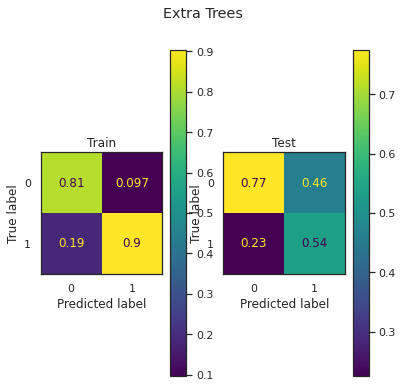

ETC_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


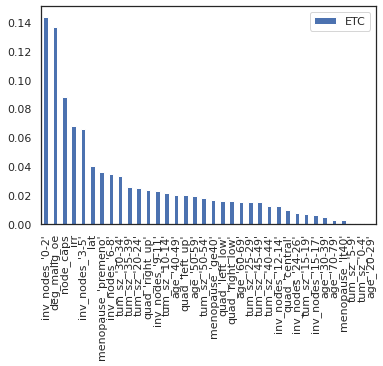

In [226]:
ETC_model = ExtraTreesClassifier(max_features=10, n_estimators=100,  max_depth = 3, random_state = 13)
ETC_model.fit(X_train, y_train)

y_pred_tr = ETC_model.predict(X_train)
y_pred_te = ETC_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
ETC_f1score = cmte.F1score
ETC_f1score

ETC_train_score = ETC_model.score(X_train, y_train)
ETC_accuracy = ETC_model.score(X_test, y_test)
print("Train: {:.2f} %".format(ETC_train_score*100))
print("Test: {:.2f} %".format(ETC_accuracy*100))
print('Overfit: {:.2f} %'.format((ETC_train_score-ETC_accuracy)*100))

plot_CM(ETC_model, "Extra Trees")

features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"ETC":features})
importances.sort_values("ETC", ascending = False, inplace=True)
importances
ETC_best_features = list(importances[importances.ETC > 0.03].index)
importances.plot.bar()
print("ETC_best_features:",ETC_best_features, len(ETC_best_features))


## GBM Classifier

/tmp/ipykernel_382/786255800.py:41: RuntimeWarning: invalid value encountered in long_scalars
  self.tpr = tp/(tp+fp)
/tmp/ipykernel_382/786255800.py:43: RuntimeWarning: invalid value encountered in long_scalars
  self.fpr = fp/(tp+fp)
/tmp/ipykernel_382/786255800.py:44: RuntimeWarning: invalid value encountered in long_scalars
  self.precision = tp/(tp+fp) # PPV
/tmp/ipykernel_382/786255800.py:64: RuntimeWarning: invalid value encountered in long_scalars
  tpr = np.round(tp/(tp+fp),2)
/tmp/ipykernel_382/786255800.py:66: RuntimeWarning: invalid value encountered in long_scalars
  fpr = np.round(fp/(tp+fp),2)
/tmp/ipykernel_382/786255800.py:78: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp) # PPV


-------------------------
       | pred n | pred p
-------------------------
cond n | tn 135  | fp 0
cond p | fn 58  | tp 0
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.7  | fpr nan
cond p | fnr 0.3  | tpr nan
----------------------------
 precision: nan
    recall: 0.00
  accuracy: 0.70
  F1-score: 0.00
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 61  | fp 0
cond p | fn 23  | tp 0
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.73  | fpr nan
cond p | fnr 0.27  | tpr nan
----------------------------
 precision: nan
    recall: 0.00
  accuracy: 0.73
  F1-score: 0.00
Train: 69.95 %
Test: 72.62 %
Overfit: -2.67 %


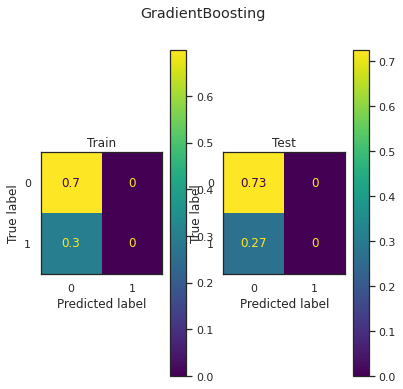

GBC_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


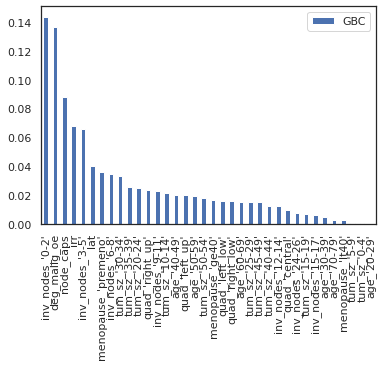

In [227]:
GBC_model = GradientBoostingClassifier(learning_rate=0.3,max_depth=4, max_features=0.6, min_samples_leaf=95, n_estimators=100, random_state = 13)
GBC_model.fit(X_train, y_train)

y_pred_tr = GBC_model.predict(X_train)
y_pred_te = GBC_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
GBM_f1score = cmte.F1score
GBM_f1score

GBC_train_score = GBC_model.score(X_train, y_train)
GBC_accuracy = GBC_model.score(X_test, y_test)
print("Train: {:.2f} %".format(GBC_train_score*100))
print("Test: {:.2f} %".format(GBC_accuracy*100))
print('Overfit: {:.2f} %'.format((GBC_train_score - GBC_accuracy)*100))

plot_CM(GBC_model, "GradientBoosting")

features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"GBC":features})
importances.sort_values("GBC", ascending = False, inplace=True)
GBC_best_features = list(importances[importances.GBC > 0.03].index)
importances.plot.bar()
print("GBC_best_features:",GBC_best_features, len(GBC_best_features))

## SGD Classifier

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 109  | fp 26
cond p | fn 24  | tp 34
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.82  | fpr 0.43
cond p | fnr 0.18  | tpr 0.57
----------------------------
 precision: 0.57
    recall: 0.59
  accuracy: 0.74
  F1-score: 0.58
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 47  | fp 14
cond p | fn 15  | tp 8
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.76  | fpr 0.64
cond p | fnr 0.24  | tpr 0.36
----------------------------
 precision: 0.36
    recall: 0.35
  accuracy: 0.65
  F1-score: 0.36
Train: 74.09 %
Test: 65.48 %
Overfit: 8.62 %


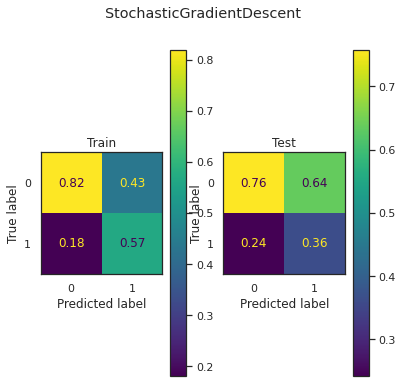

SGD_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


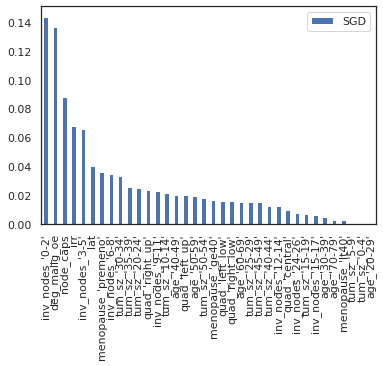

In [228]:
SGD_model = SGDClassifier(alpha=0.001, penalty='elasticnet', loss='modified_huber', random_state=13)
SGD_model.fit(X_train, y_train)

y_pred_tr = SGD_model.predict(X_train)
y_pred_te = SGD_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
SGD_f1score = cmte.F1score
SGD_f1score

SGD_train_score = SGD_model.score(X_train, y_train)
SGD_accuracy = SGD_model.score(X_test, y_test)
print("Train: {:.2f} %".format(SGD_train_score*100))
print("Test: {:.2f} %".format(SGD_accuracy*100))
print('Overfit: {:.2f} %'.format((SGD_train_score-SGD_accuracy)*100))

plot_CM(SGD_model, "StochasticGradientDescent")

features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"SGD":features})
importances.sort_values("SGD", ascending = False, inplace=True)
SGD_best_features = list(importances[importances.SGD > 0.03].index)
importances.plot.bar()
print("SGD_best_features:",SGD_best_features, len(SGD_best_features))


## Decision Tree Classifier

-------------------------
       | pred n | pred p
-------------------------
cond n | tn 126  | fp 9
cond p | fn 32  | tp 26
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.8  | fpr 0.26
cond p | fnr 0.2  | tpr 0.74
----------------------------
 precision: 0.74
    recall: 0.45
  accuracy: 0.79
  F1-score: 0.56
-------------------------
       | pred n | pred p
-------------------------
cond n | tn 56  | fp 5
cond p | fn 16  | tp 7
-------------------------
----------------------------
       | pred n   | pred p
----------------------------
cond n | tnr 0.78  | fpr 0.42
cond p | fnr 0.22  | tpr 0.58
----------------------------
 precision: 0.58
    recall: 0.30
  accuracy: 0.75
  F1-score: 0.40
Train: 78.76 %
Test: 75.00 %
Overfit: 3.76 %


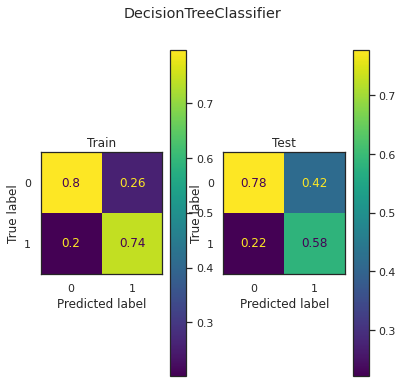

DT_best_features: ["inv_nodes_'0-2'", 'deg_malig_oe', 'node_caps', 'irr', "inv_nodes_'3-5'", 'lat', "menopause_'premeno'", "inv_nodes_'6-8'", "tum_sz_'30-34'"] 9


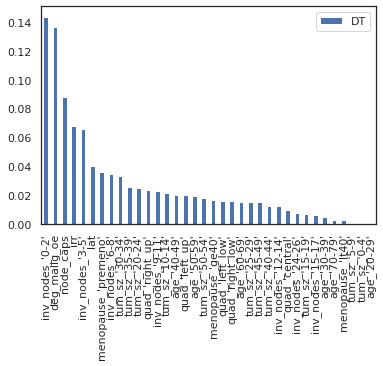

In [231]:
DT_model = DecisionTreeClassifier(criterion='entropy', max_depth=3,max_features=0.9, min_samples_leaf=8,min_samples_split=5, random_state=13)
DT_model.fit(X_train, y_train)

y_pred_tr = DT_model.predict(X_train)
y_pred_te = DT_model.predict(X_test)

cmtr = cmbw(y_train, y_pred_tr)
cmtr.prntcmt()
cmtr.prntcmp()
cmtr.prntpr()

cmte = cmbw(y_test, y_pred_te)
cmte.prntcmt()
cmte.prntcmp()
cmte.prntpr()
DT_f1score = cmte.F1score
DT_f1score

DT_train_score = DT_model.score(X_train, y_train)
DT_accuracy = DT_model.score(X_test, y_test)
print("Train: {:.2f} %".format(DT_train_score*100))
print("Test: {:.2f} %".format(DT_accuracy*100))
print('Overfit: {:.2f} %'.format((DT_train_score - DT_accuracy)*100))

plot_CM(DT_model, "DecisionTreeClassifier")

features = {}
for feature, importance in zip(X_cols, rf_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"DT":features})
importances.sort_values("DT", ascending = False, inplace=True)
DT_best_features = list(importances[importances.DT > 0.03].index)
importances.plot.bar()
print("DT_best_features:",DT_best_features, len(DT_best_features))


## Features

In [214]:
L = min(len(RF_best_features), len(XGB_features), len(ADA_best_features), len(KNN_best_features), len(LR_best_features), len(SVM_best_features), 
        len(ETC_best_features), len(GBC_best_features), len(SGD_best_features), len(DT_best_features))

TF = pd.DataFrame({"ADA":ADA_best_features[:L], "KNN": KNN_best_features[:L], "LR": LR_best_features[:L],
                  "SVM":SVM_best_features[:L], "XGB":XGB_features[:L], "RF":RF_best_features[:L],
                  "ETC":ETC_best_features[:L], "GBC":GBC_best_features[:L], "SGD":SGD_best_features[:L],
                  "DT": DT_best_features} )
TF



,ADA,KNN,LR,SVM,XGB,RF,ETC,GBC,SGD,DT
0,inv_nodes_'0-2',inv_nodes_'0-2',inv_nodes_'0-2',inv_nodes_'0-2',f24,inv_nodes_'0-2',inv_nodes_'0-2',inv_nodes_'0-2',inv_nodes_'0-2',inv_nodes_'0-2'
1,deg_malig_oe,deg_malig_oe,deg_malig_oe,deg_malig_oe,f0,deg_malig_oe,deg_malig_oe,deg_malig_oe,deg_malig_oe,deg_malig_oe
2,node_caps,node_caps,node_caps,node_caps,f3,node_caps,node_caps,node_caps,node_caps,node_caps
3,irr,irr,irr,irr,f2,irr,irr,irr,irr,irr
4,inv_nodes_'3-5',inv_nodes_'3-5',inv_nodes_'3-5',inv_nodes_'3-5',f28,inv_nodes_'3-5',inv_nodes_'3-5',inv_nodes_'3-5',inv_nodes_'3-5',inv_nodes_'3-5'
5,lat,lat,lat,lat,f29,lat,lat,lat,lat,lat
6,menopause_'premeno',menopause_'premeno',menopause_'premeno',menopause_'premeno',f35,menopause_'premeno',menopause_'premeno',menopause_'premeno',menopause_'premeno',menopause_'premeno'
7,inv_nodes_'6-8',inv_nodes_'6-8',inv_nodes_'6-8',inv_nodes_'6-8',f30,inv_nodes_'6-8',inv_nodes_'6-8',inv_nodes_'6-8',inv_nodes_'6-8',inv_nodes_'6-8'
8,tum_sz_'30-34',tum_sz_'30-34',tum_sz_'30-34',tum_sz_'30-34',f18,tum_sz_'30-34',tum_sz_'30-34',tum_sz_'30-34',tum_sz_'30-34',tum_sz_'30-34'


In [215]:
print("Accuracy Scores:")
print("==========================================================")
print("DNN: {:.3f}".format(dnn_accuracy))
print("RandomForest: {:.3f}".format(rf_accuracy))
print("XGBoost classifier: {:.3f}".format(xgb_accuracy))
print("SVM classifier: {:.3f}".format(SVM_accuracy))
print("LR classifier: {:.3f}".format(LR_accuracy))
print("KNN classifier: {:.3f}".format(KNN_accuracy))
print("ADA Boost classifier: {:.3f}".format(ADA_accuracy))
print("Extra Tree classifier: {:.3f}".format(ETC_accuracy))
print("Gradient Boosting classifier: {:.3f}".format(GBC_accuracy))
print("Stochastic Gradient descent: {:.3f}".format(SGD_accuracy))
print("Decision Tree classifier: {:.3f}".format(DT_accuracy))
print("==========================================================")


Accuracy Scores:
DNN: 0.702
RandomForest: 0.762
XGBoost classifier: 0.738
SVM classifier: 0.726
LR classifier: 0.702
KNN classifier: 0.738
ADA Boost classifier: 0.750
Extra Tree classifier: 0.738
Gradient Boosting classifier: 0.726
Stochastic Gradient descent: 0.655
Decision Tree classifier: 0.750


In [232]:
print("F1 Scores:")
print("==========================================================")
print("DNN: {:.3f}".format(dnn_f1score))
print("RandomForest: {:.3f}".format(rf_f1score))
print("XGBoost classifier: {:.3f}".format(xgb_f1score))
print("SVM classifier: {:.3f}".format(SVM_f1score))
print("LR classifier: {:.3f}".format(LR_f1score))
print("KNN classifier: {:.3f}".format(KNN_f1score))
print("ADA Boost classifier: {:.3f}".format(ADA_f1score))
print("Extra Tree classifier: {:.3f}".format(ETC_f1score))
print("Gradient Boosting classifier: {:.3f}".format(GBM_f1score))
print("Stochastic Gradient descent: {:.3f}".format(SGD_f1score))
print("Decision Tree classifier: {:.3f}".format(DT_f1score))
print("==========================================================")


F1 Scores:
DNN: 0.000
RandomForest: 0.375
XGBoost classifier: 0.083
SVM classifier: 0.378
LR classifier: 0.324
KNN classifier: 0.267
ADA Boost classifier: 0.462
Extra Tree classifier: 0.389
Gradient Boosting classifier: 0.000
Stochastic Gradient descent: 0.356
Decision Tree classifier: 0.400
